In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as sts # adf test
import statsmodels.graphics.tsaplots as sgt # plot acf
import statsmodels.tsa.statespace.sarimax as sarimax

# Apply moving average process to sales dataset

In [2]:
df = pd.read_csv('widget_sales.csv')

In [3]:
# we know before hand this sales start at January 1.
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


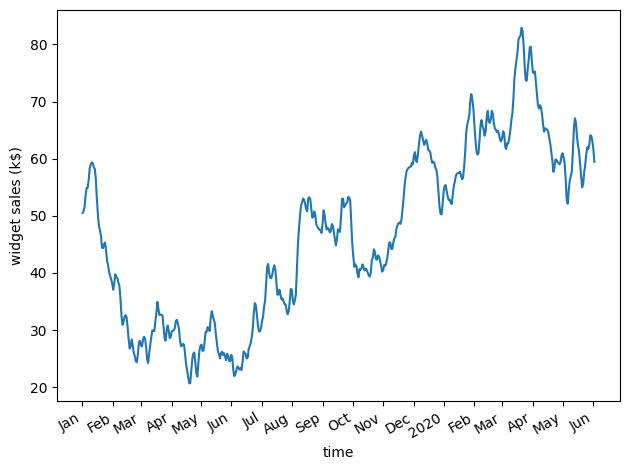

In [4]:
fig, ax = plt.subplots()

ax.plot(df.widget_sales)

ax.set_xlabel('time')
ax.set_ylabel('widget sales (k$)')

# did not find a better way to break lines better (80 char rule), 
# sorry fellas
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 
         323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 
         'Feb', 'Mar', 'Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

the steps are pretty similar to what we have already done:
1. test for stationarity
2. if not convert to stationary
3. plot acf and see correlation

In [5]:
adf = sts.adfuller(df.widget_sales)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -1.5121662069358999
p-value 0.5274845352272628


p value is larger than 0.05 so no stationary here, let's transform it

In [6]:
diff_widget_sales = np.diff(df.widget_sales)

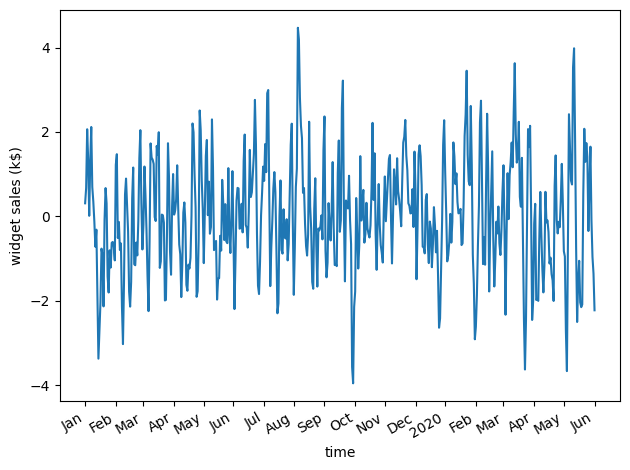

In [8]:
fig, ax = plt.subplots()

ax.plot(diff_widget_sales)

ax.set_xlabel('time')
ax.set_ylabel('widget sales (k$)')

# did not find a better way to break lines better (80 char rule), 
# sorry fellas
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 
         323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 
         'Feb', 'Mar', 'Apr', 'May', 'Jun']
)

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
diff_adf = sts.adfuller(diff_widget_sales)
print(f'adf statistic {diff_adf[0]}')
print(f'p-value {diff_adf[1]}')

adf statistic -10.576657780341959
p-value 7.076922818587193e-19


Okay not it is stationary let's see the ACF correlation

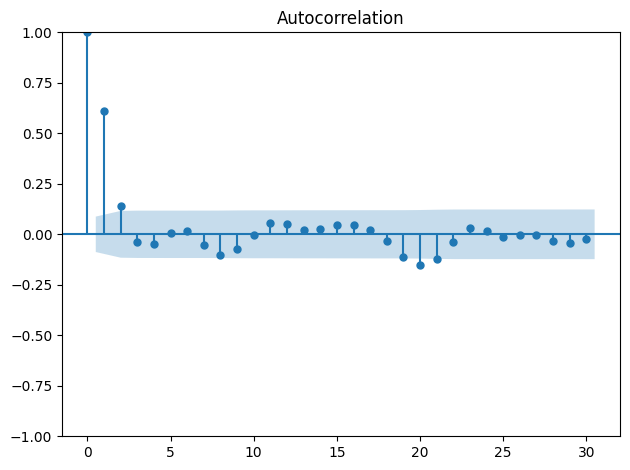

In [10]:
sgt.plot_acf(diff_widget_sales, lags = 30)
plt.tight_layout()

we can see that there are significant coefficients up until lag 2. This means we can use 2 as the order (q) in MA process

### moving average model of second order

remeber that MA requires the dataset to be stationary so we need to train and test against the diff dataset, the we can transform back

In [11]:
df_diff = pd.DataFrame({'widget_sales_diff': diff_widget_sales})

In [13]:
# we'll use 90% to train and 10% to test
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

In [15]:
# so we can graph the gray area and so on
print(len(train))
print(len(test))

449
50


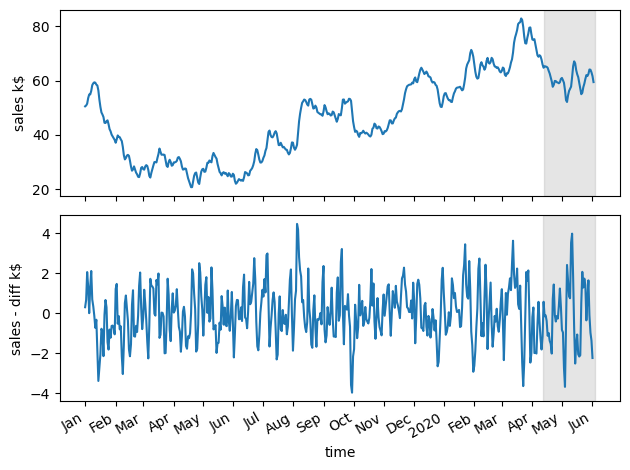

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True)

ax1.plot(df.widget_sales)
ax1.set_ylabel('sales k$')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff.widget_sales_diff)
ax2.set_xlabel('time')
ax2.set_ylabel('sales - diff k$')
ax2.axvspan(len(train), 500, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409,
     439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
     'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])


fig.autofmt_xdate()
plt.tight_layout()

### rolling forecasting

Since `p = 2` we will only take 2 past errors to calc each value. We
can not take this and calculate 50 timesteps into the future. Becuase we dont
have the 2 past error for future values.

What we can do is called **rolling forecasting** which basically is iterate the
training, and based on new results obtain values further in the future

say we have 10 steps, and a q of 2. The first iteration we can predict until
12, the second one we will take the new values and train with those so we will
be able to go until 14.

but before having fun, let's set up some baselines to have something to compare to. So we will build function that can do all this things :). And by build I mean copying from the book

In [39]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,
                     window: int, method: str) -> list:
    '''
    given a dataset, forecast using one of three methods:

        1. historical mean (mean)
        2. last value  (last)
        3. moving average (MA)

    :param pd.DataFrame df: data frame with two columns
    :param int train_len: number of data point that can be used to fit the
                          model
    :param int horizon: lenght of the test set, how many values we want to
                        predict
    :param int window: how many timesteps are predicted at a time
                       (ex: MA(2) -> 2)
    :param int method: mean | last | MA, method used to do the forecast

    :return:
    :rtype: list
    '''

    # train lenght + the horizon make the total lenght of the dataset
    # meaning it includes the prediction as well
    total_len = train_len + horizon

    if method.lower() == 'mean':
        pred_mean = []

        # go from last train value to total lenght, step by step
        for i in range(train_len, total_len, window):
            # this means calcuating the mean thru each timestep
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range (window))

        return pred_mean

    if method.lower() == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    if method.lower() == 'ma':
        pred_ma = []

        for i in range (train_len, total_len, window):
            # FIXME: shouldn't this stop where the training set ends
            # and start adding the predictions on top of that, so
            # ... 80 90 <train set end>  94 96 based on these new 
            # values calc next ones.
            model = sarimax.SARIMAX(df[:i], order = (0, 0, 2))
            r = model.fit(disp = False)
            predictions = r.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ma.extend(oos_pred)

        return pred_ma

    return []

Let's make a predictions dataframe with our test data and the prediction for these models

In [40]:
TRAIN_LEN = len(train) # 449
HORIZON = len(test) # 50
WINDOW = 2

In [41]:
pred_df = test.copy()

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')

pred_last_value = rolling_forecast(df_diff, TRAIN_LEN,
                                    HORIZON, WINDOW, 'last')

pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ma')

In [48]:
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head(20)

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994
454,-1.118891,0.032183,-0.096564,0.115810
455,-0.979693,0.028764,-1.118891,-0.795666
456,-1.369431,0.028764,-1.118891,-0.191286
457,-1.517477,0.023498,-1.369431,-0.922824
458,-2.006735,0.023498,-1.369431,-0.254060


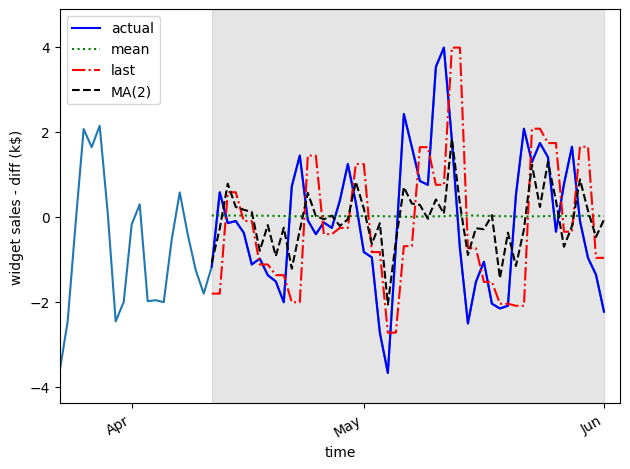

In [47]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label = 'actual')
ax.plot(pred_df['pred_mean'], 'g:', label = 'mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label = 'last')
ax.plot(pred_df['pred_MA'], 'k--', label = 'MA(2)')

ax.legend(loc = 2)

ax.set_xlabel('time')
ax.set_ylabel('widget sales - diff (k$)')

ax.axvspan(449, 498, color = '#808080', alpha = 0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
